## **Libraries**

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import cv2
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from PIL import Image

import os

%matplotlib inline

## **Data**

In [2]:
# Import data as dataframe
data = pd.read_csv("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv")
test = pd.read_csv("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/sample_submission.csv")

In [3]:
# Display data dataframe
data

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


In [4]:
# Display test dataframe
test

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,14 1 0 0 1 1
2,008bdde2af2462e86fd373a445d0f4cd,14 1 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 1 0 0 1 1
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,14 1 0 0 1 1
2996,ff9fcc4087ed5e941209aa3fa948e364,14 1 0 0 1 1
2997,ffaa288c8abca300974f043b57d81521,14 1 0 0 1 1
2998,ffc441e0c8b7153844047483a577e7c3,14 1 0 0 1 1


In [5]:
# Display information on the 'data' dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 4.1+ MB


In [6]:
# Some statistics on the 'data' dataframe
data.describe()

,class_id,x_min,y_min,x_max,y_max
count,67914.000000,36096.000000,36096.000000,36096.000000,36096.000000
mean,9.979312,1051.332696,1065.262051,1492.269337,1456.660489
std,5.036494,565.838078,552.925133,595.384126,581.134138
min,0.000000,0.000000,0.000000,68.000000,103.000000
25%,7.000000,602.000000,627.000000,1010.000000,1009.000000
50%,13.000000,1014.500000,935.000000,1567.000000,1411.000000
75%,14.000000,1457.000000,1471.000000,1947.000000,1911.000000
max,14.000000,2934.000000,3133.000000,3131.000000,3384.000000


## **Data visualisation**

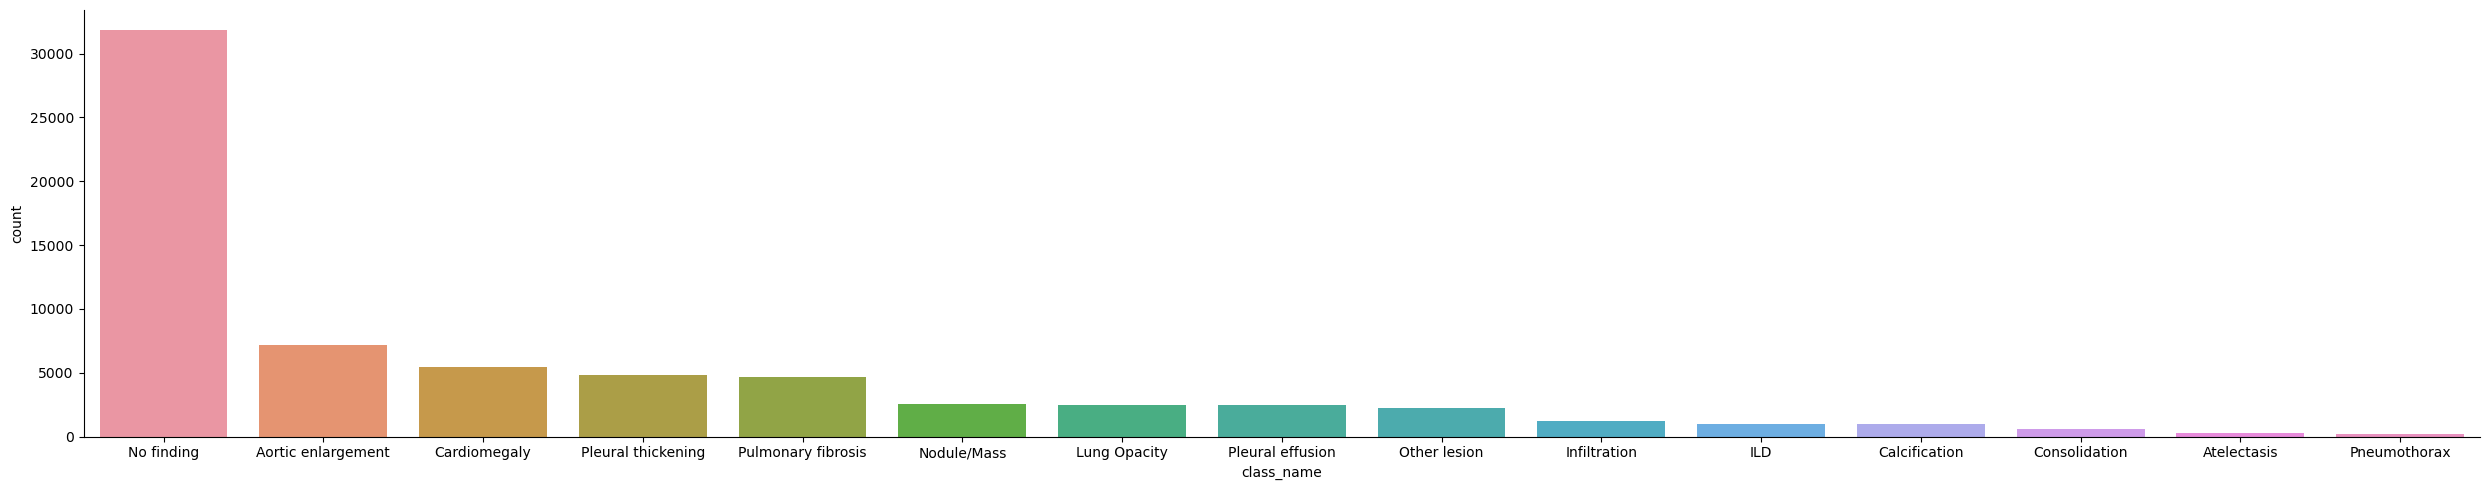

In [7]:
# Display the count for all abnormalities
sns.catplot(data=data, x="class_name", kind="count", height=5, aspect=5, order=data['class_name'].value_counts().index)

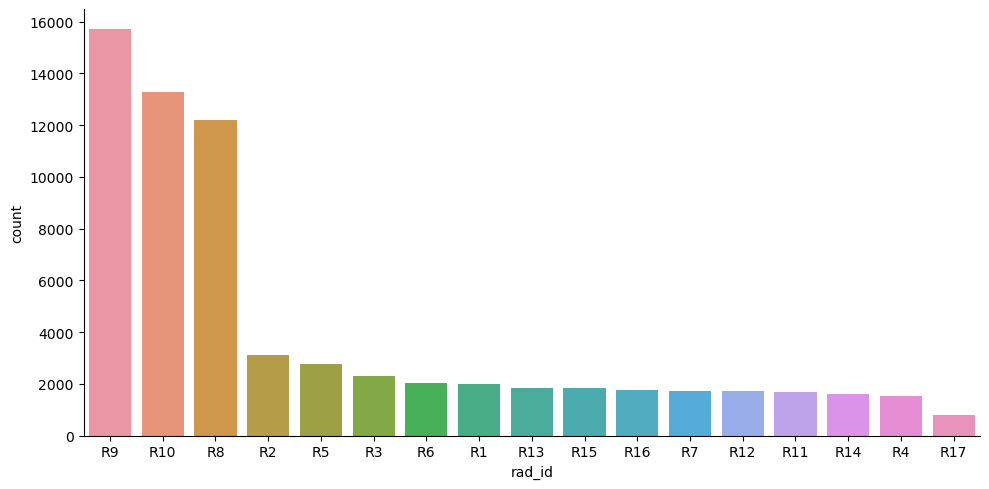

In [8]:
# Display the number of diagnoses per radiologists
sns.catplot(data=data, x="rad_id", kind="count", aspect=2, order=data['rad_id'].value_counts().index)

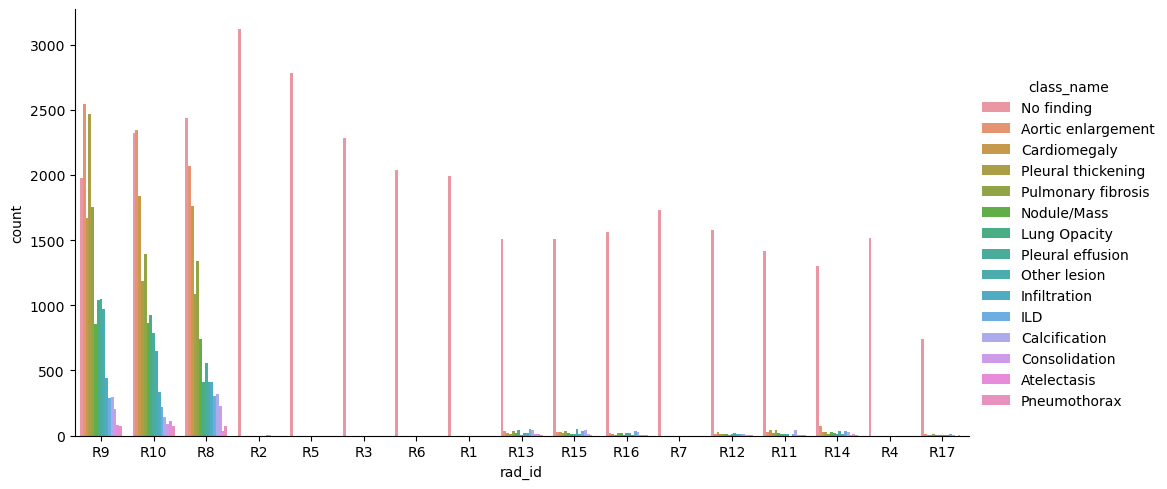

In [9]:
# Display the number of diagnoses per radiologists and per abnormalities
sns.catplot(data=data, x="rad_id", kind="count", hue = "class_name", hue_order=data['class_name'].value_counts().index , aspect=2, order=data['rad_id'].value_counts().index)

In [10]:
# Creating 2 dataframes from 'data'
# One with the 14 classes
# The other one with only the class "No Finding"
data_14 = data[data.class_id!=14].reset_index(drop = True)
data_1 = data[data.class_id==14].reset_index(drop = True)

In [11]:
# Display the dataframe with the 14 different classes
data_14

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0


In [12]:
# Display the dataframe with only the class "No Finding"
data_1

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
3,5550a493b1c4554da469a072fdfab974,No finding,14,R9,NaN,NaN,NaN,NaN
4,869f39afbdd8783b531530942eda8bad,No finding,14,R3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
31813,955f258cc29153f996ee6716218c1196,No finding,14,R8,NaN,NaN,NaN,NaN
31814,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
31815,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
31816,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN


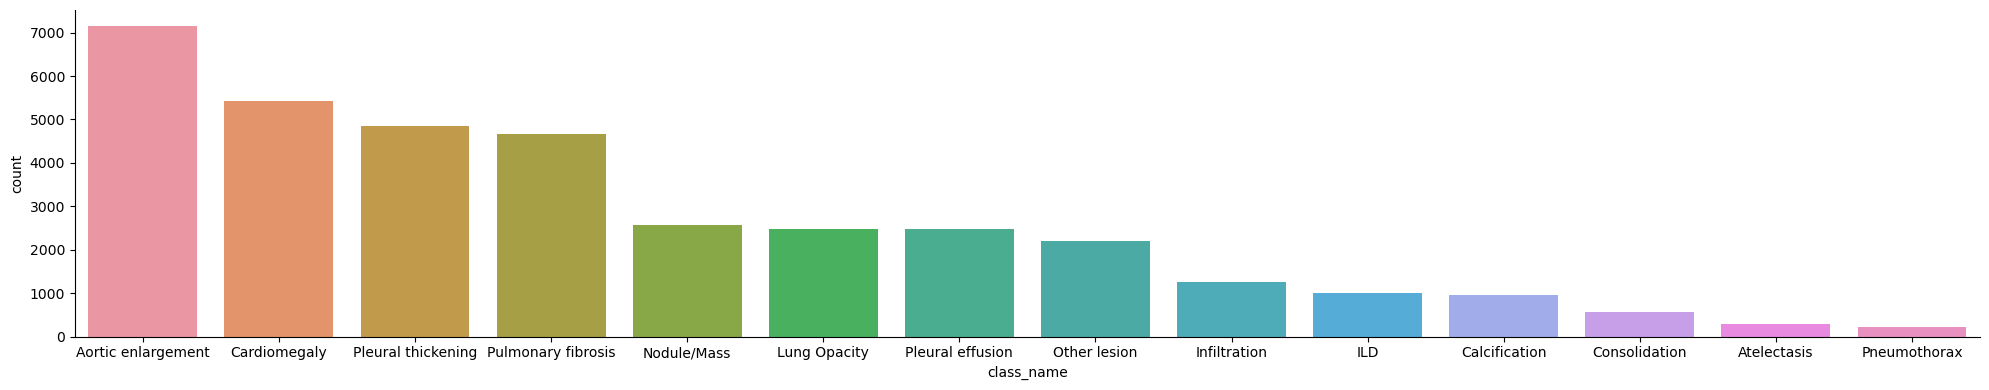

In [13]:
# Display the count for all abnormalities
sns.catplot(data=data_14, x="class_name", kind="count", height=4, aspect=5, order=data_14['class_name'].value_counts().index)

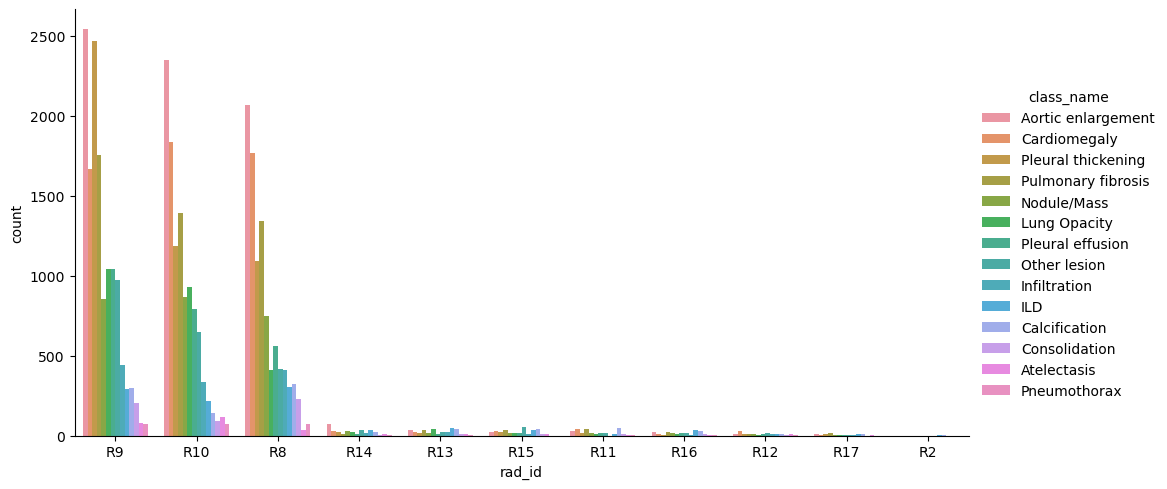

In [14]:
# Display again the number of diagnoses per radiologists and per abnormalities
sns.catplot(data=data_14, x="rad_id", kind="count", hue = "class_name", hue_order=data_14['class_name'].value_counts().index , aspect=2, order=data_14['rad_id'].value_counts().index)

In [15]:
# Function that creates an array from a DICOM image
# INPUT: path of the DICOM image
# OUPUT: array of the corresponding image
def read_xray(path, voi_lut = True, fix_monochrome = True):
    
    # Reading DICOM image
    dicom = pydicom.read_file(path)
    
    # Using VOI LUT (if available by DICOM device) to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # Depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    # Standardizing the array
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "


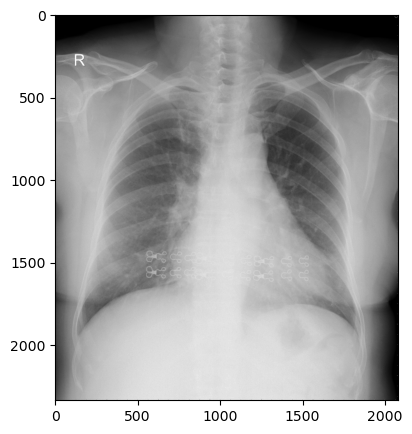

In [16]:
# Display a chest X-ray image
img = read_xray('/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/9a5094b2563a1ef3ff50dc5c7ff71345.dicom')
plt.figure(figsize = (5,5))
plt.imshow(img, 'gray')

In [17]:
print("Number of images in the dataframe with 14 classes: ", data_14['image_id'].nunique())
print("Number of images in the dataframe with only 1 class: ", data_1['image_id'].nunique())

Number of images in the dataframe with 14 classes:  4394
Number of images in the dataframe with only 1 class:  10606


## **Pre-Processing**

In [18]:
# Function that converts DICOM to JPG images and that recovers the height/width for each image
# INPUT: path of the image, image_id, a dictionnary to save results, path of the output folder
# OUPUT: None
def convert_dicom_to_jpg(path_image, image_id, dico, final_fodler, voi_lut = True, fix_monochrome = True):
    
    # Retrieving the image path
    path = path_image + image_id + '.dicom'
    
    # Reading DICOM image
    dicom = pydicom.read_file(path)
    
    # Using VOI LUT (if available by DICOM device) to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # Depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    # Standardizing the array
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    # Saving image shape into the dictionnary
    dico[id] = data.shape
    
    # Converting array to PIL Image
    img = Image.fromarray(data)
    
    # Creating final path for the new image
    final_path = final_fodler +  image_id + '.jpg'
    
    # Saving image as JPG
    img.save(final_path)

### **TRAINING IMAGES**

In [19]:
# Creating a dictionnary to save the shapes
dico_images_shape = {}

# Creating a final folder
final_fodler = '/kaggle/working/vinbigdata-images-jpg/train/'
os.makedirs(final_fodler, exist_ok = True)

# Working only on the "train" images
path_image = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/'

# Convert all images to JPG
for id in tqdm(data['image_id'].unique()):
    convert_dicom_to_jpg(path_image, id, dico_images_shape, final_fodler)

  0%|          | 0/15000 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "


In [20]:
import shutil

# Converting the final folder to zip file
shutil.make_archive('dataset-images-jpg', 'zip', '/kaggle/working/vinbigdata-images-jpg/train')

'/kaggle/working/dataset-images-jpg.zip'

In [21]:
width = []
height = []

# Recovering only the height/width of images belonging to the dataframe 'data_14'
for id in data_14['image_id']:
    width.append(dico_images_shape[id][1])
    height.append(dico_images_shape[id][0])

# Creating corresponding columns
data_14['width'] = width
data_14['height'] = height

# Saving the dataframe 'data_14' to csv as 'train_with_sizes.csv'
data_14.to_csv('train_with_sizes.csv', index=False)

### **TEST IMAGES**

In [22]:
# Creating a dictionnary to save the shapes
dico_images_shape = {}

# Creating a final folder
final_fodler = '/kaggle/working/vinbigdata-images-jpg/test/'
os.makedirs(final_fodler, exist_ok = True)

# Working only on the "test" images
path_image = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/test/'

# Convert all images to JPG
for id in tqdm(test['image_id'].unique()):
    convert_dicom_to_jpg(path_image, id, dico_images_shape, final_fodler)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [23]:
import shutil

# Converting the final folder to zip file
shutil.make_archive('dataset-submission-images-jpg', 'zip', '/kaggle/working/vinbigdata-images-jpg/test')

'/kaggle/working/dataset-submission-images-jpg.zip'

In [24]:
width = []
height = []

# Recovering only the height/width of images belonging to the dataframe 'test'
for id in test['image_id']:
    width.append(dico_images_shape[id][1])
    height.append(dico_images_shape[id][0])

# Creating corresponding columns
test['width'] = width
test['height'] = height

# Saving the dataframe 'test' to csv as 'train_with_sizes.csv'
test.to_csv('sample_submission_with_sizes.csv', index=False)